## Business Understanding

### Цель проекта - классификация качества вина

Вино - это алкогольный напиток, приготовленный из винограда. Дрожжи поглощают сахар, содержащийся в винограде, и преобразуют его в этанол, углекислый газ и тепло. Безусловно, будет интересно проанализировать физико-химические свойства вина и понять их взаимосвязь и значение с классификацией качества и типов вина. Для этого мы будем действовать в соответствии с моделями рабочего процесса машинного обучения и интеллектуального анализа данных, такими как модель CRISP-DM, в основном для:

Определить, является ли каждый образец вина красным или белым.
Прогнозировать качество каждого образца вина, которое может быть низким, средним или высоким.

Входные переменные (на основе физико-химических тестов):

    fixed acidity фиксированная кислотность
    volatile acidity летучая кислотность
    citric acid лимонная кислота
    residual sugar остаточный сахар
    chlorides хлориды
    free sulfur dioxide свободный диоксид серы
    total sulfur dioxide диоксид серы общий
    density плотность
    рН
    sulphates сульфаты
    alcohol алкоголь


## Data Understanding

### Необходдимые импорты 

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import metrics, tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.preprocessing import StandardScaler

### EDA 

In [2]:
wines = pd.read_csv('winequalityN.csv')
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Видим, что есть небольшое количество выбросов и пустых значений, удалим эти строчки

In [5]:
wines.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [6]:
wines.dropna(inplace=True)

In [7]:
wines.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
wines['type'].value_counts()

white    4870
red      1593
Name: type, dtype: int64

In [9]:
wines = pd.get_dummies(wines, columns=['type'])
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


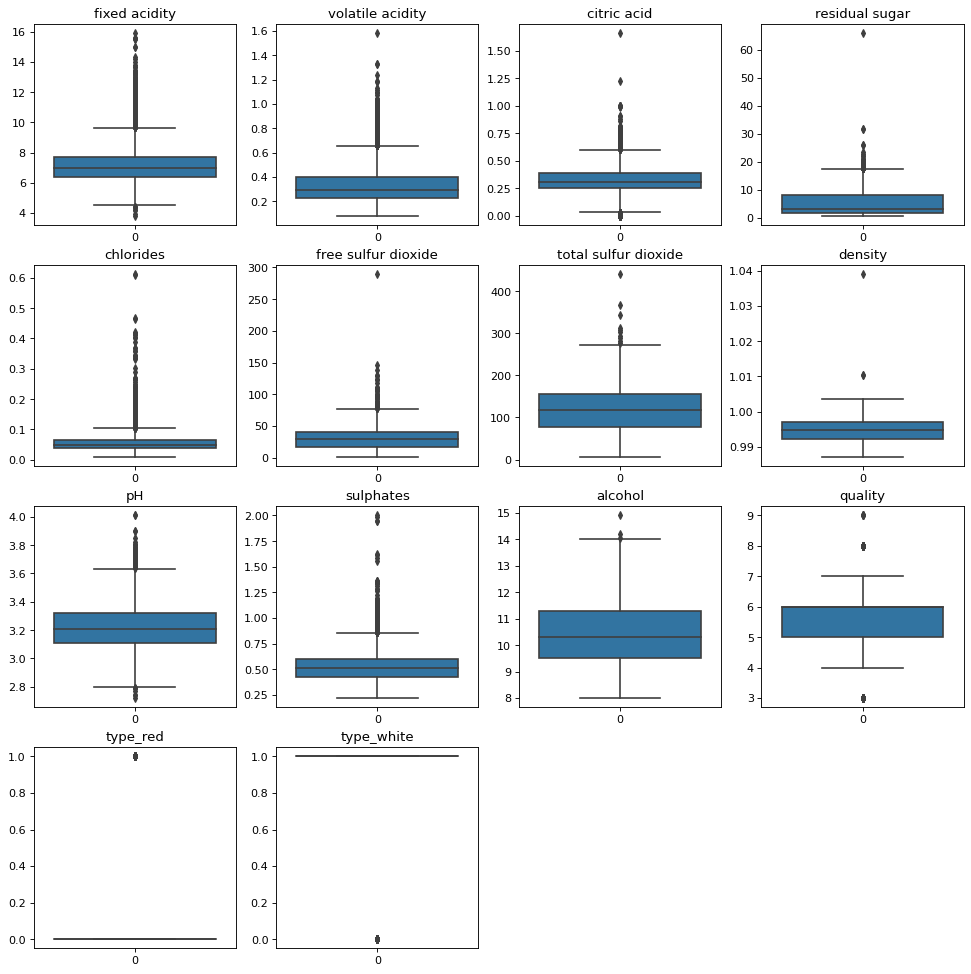

In [10]:
plt.figure(figsize=(15, 15), dpi=80)
for id, i in enumerate(wines.columns):
  plt.subplot(4, 4, id + 1)
  sns.boxplot(data=wines.loc[:, i])
  plt.title(i)

Смотрим баланс классов, сильно несбалансированные классы

In [11]:
wines['quality'].value_counts()

6    2820
5    2128
7    1074
4     214
8     192
3      30
9       5
Name: quality, dtype: int64

Посмотрим есть ли сильная корреляция

<Axes: >

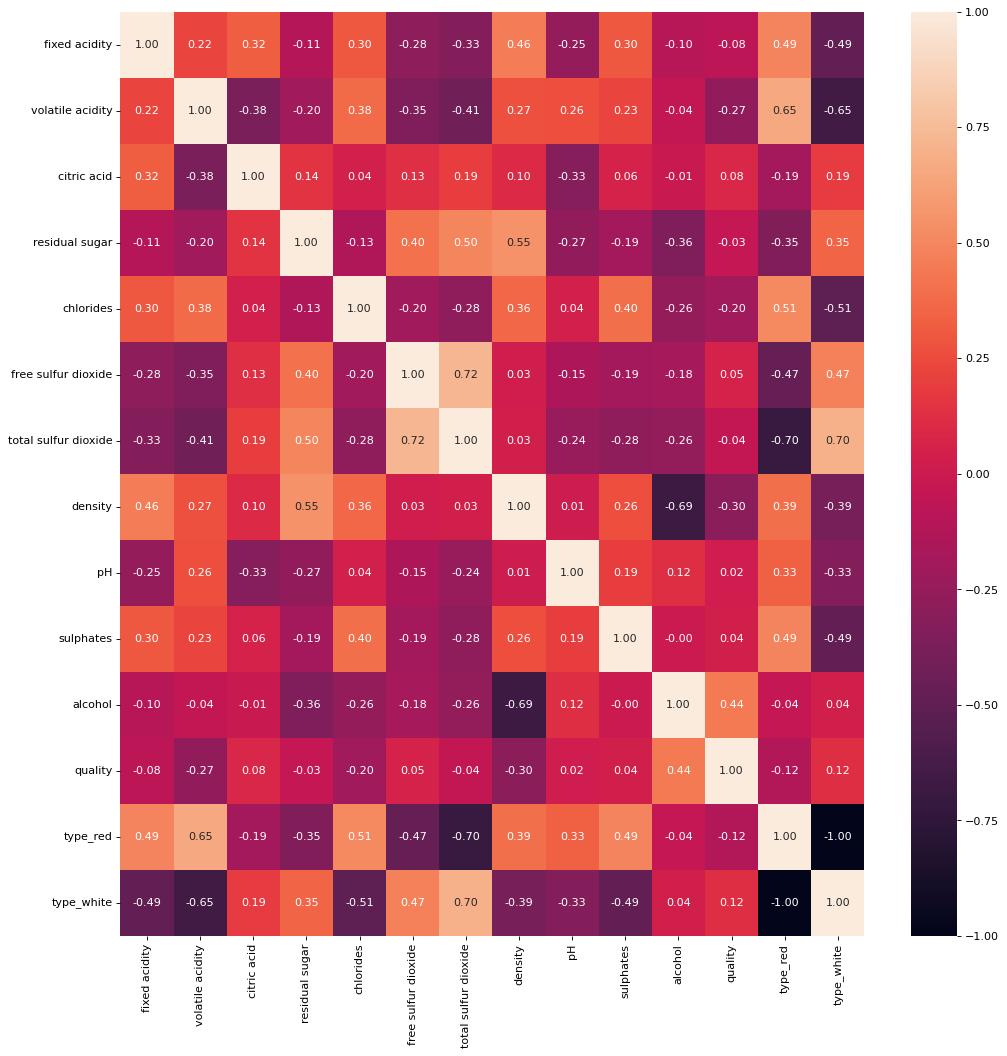

In [12]:
plt.figure(figsize=(15, 15), dpi=80)
sns.heatmap(wines.corr(), annot=True, fmt=".2f")

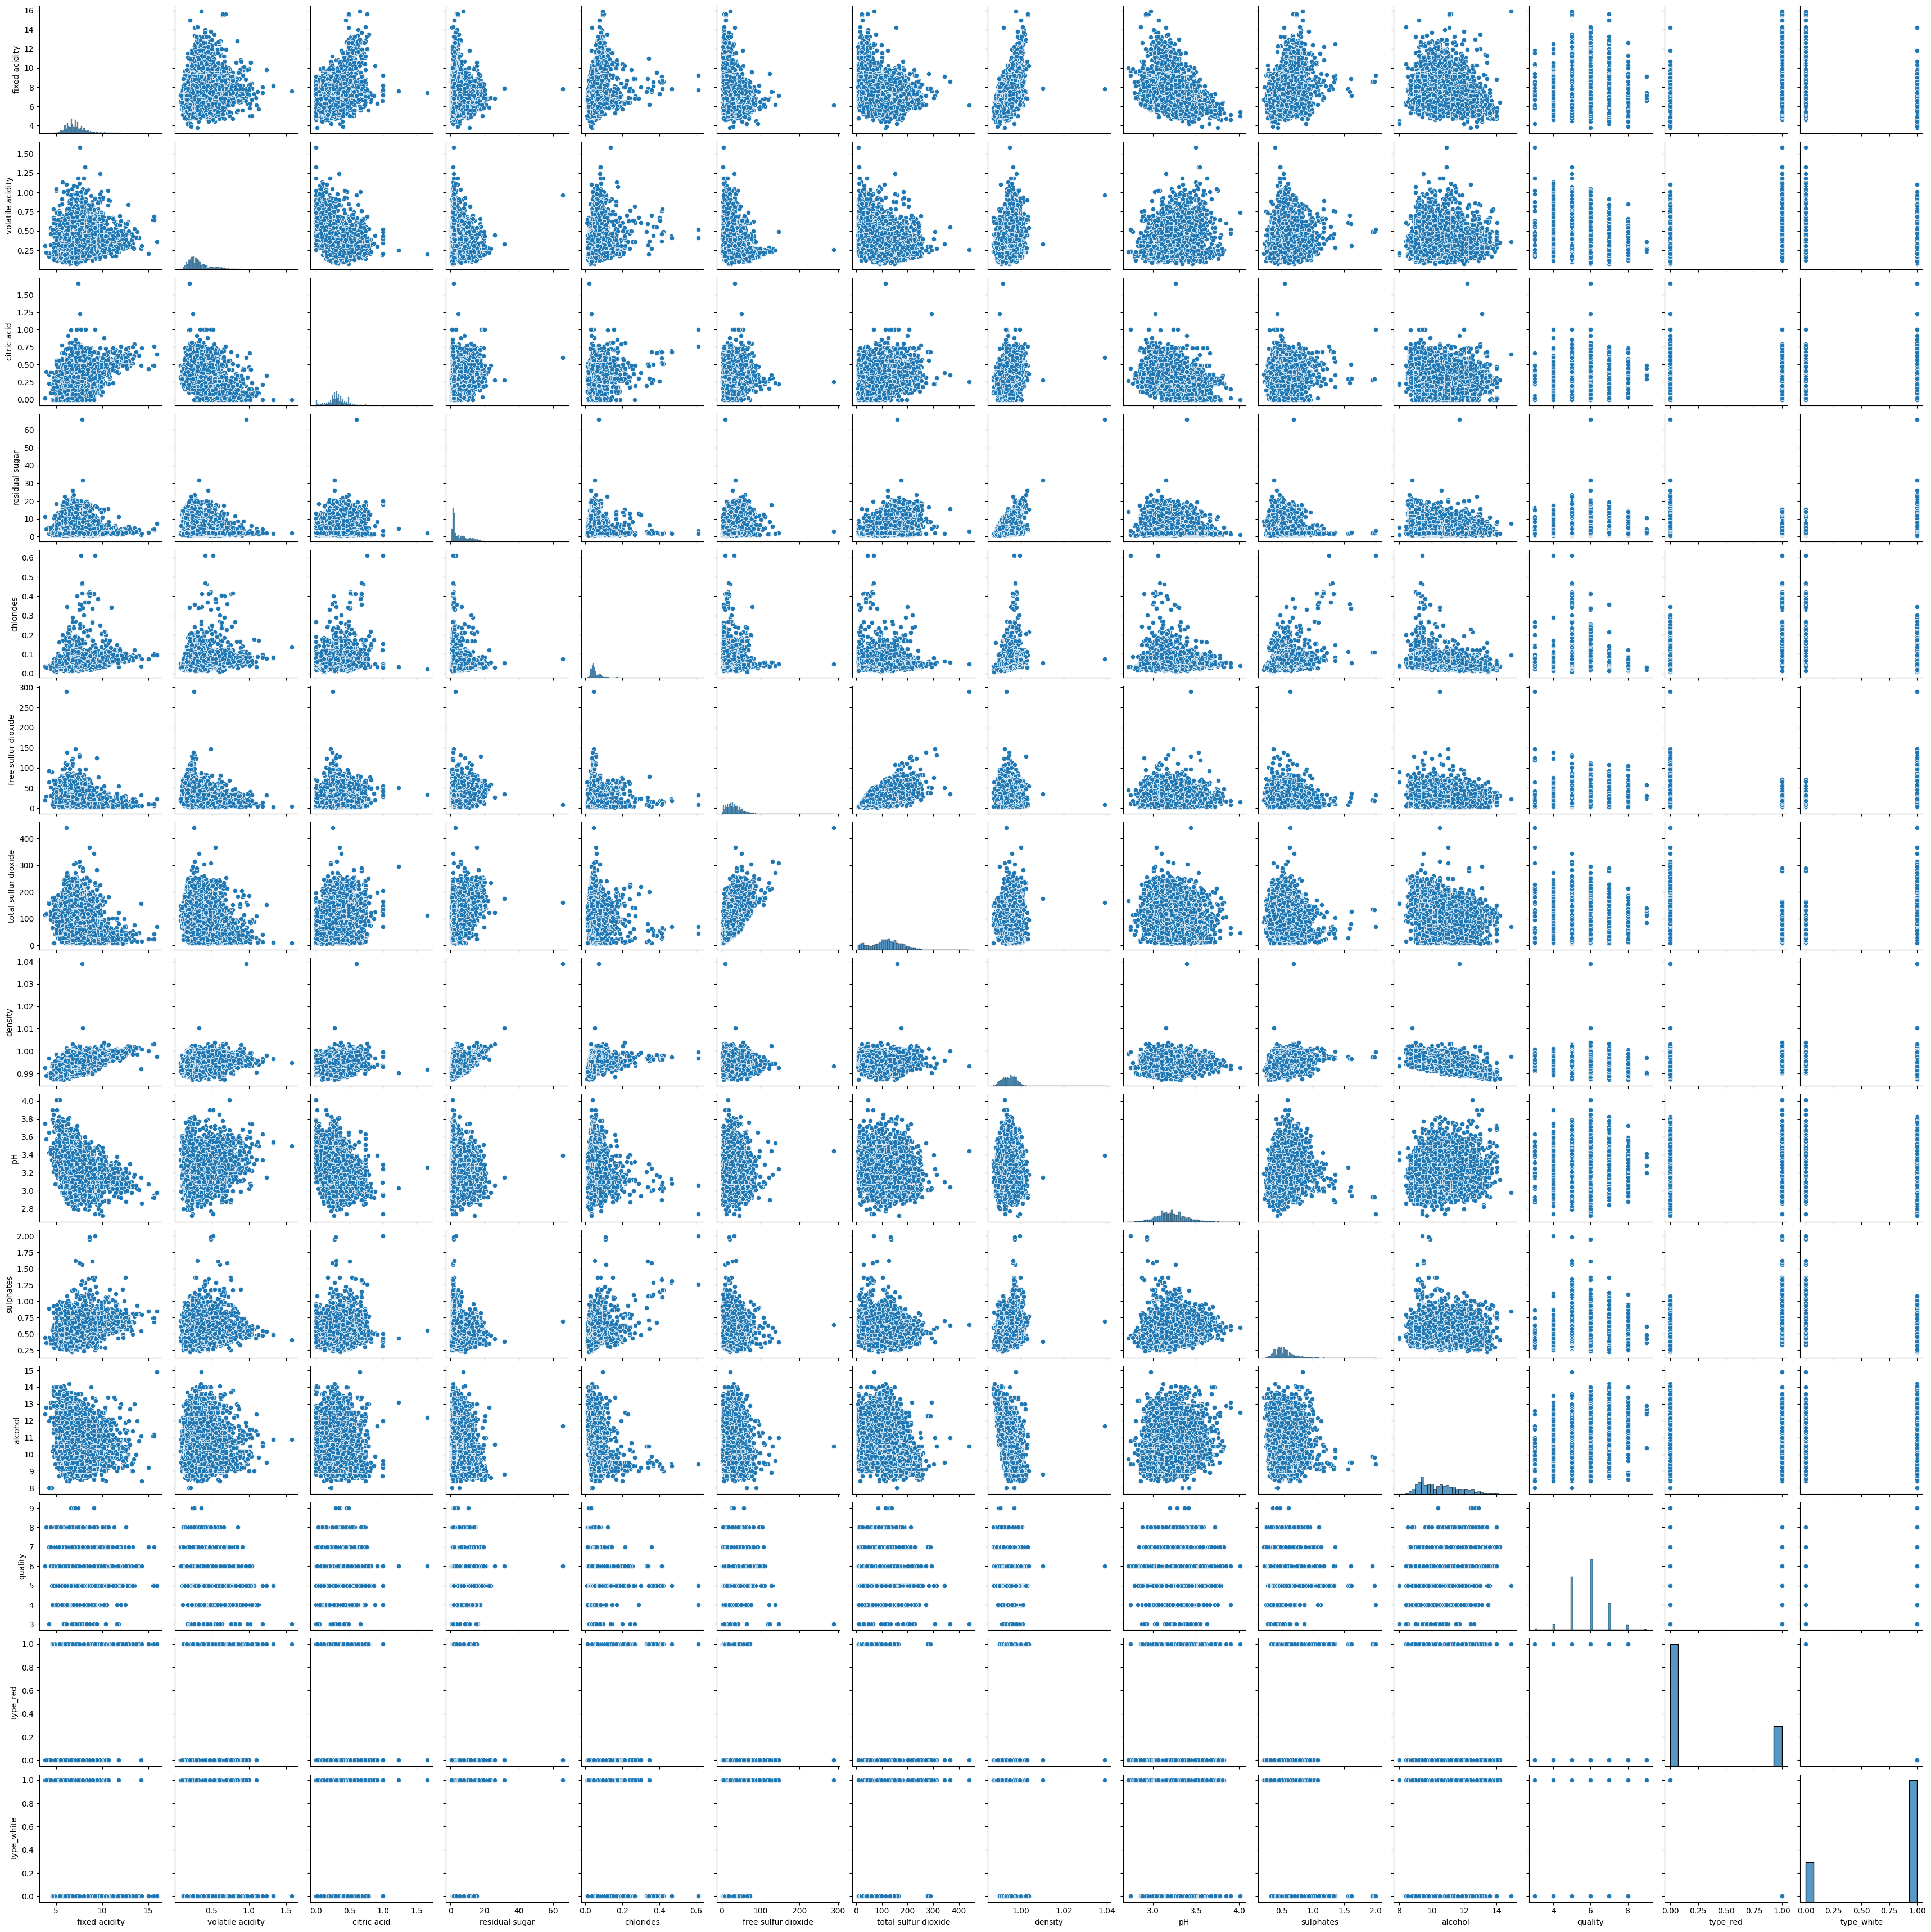

In [14]:
sns.pairplot(data = wines)

## Data Preparation

In [21]:
X = wines.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,12,13]]
y = wines.iloc[:,[11]]

In [27]:
# Построим base line 
simple_lr = cross_val_score(LogisticRegression(solver='newton-cg', max_iter=1000), X, y.values.ravel(), scoring='accuracy').mean()
simple_lr

0.5152392377148686

In [28]:
# Найдем индексы строк с выбросами
outliers_indexes = []

for feature in X:
  Q1 = np.percentile(wines[feature], 15)
  Q3 = np.percentile(wines[feature], 85)
  IQR = Q3 - Q1
  outliers = 1.5 * IQR
  outliers_indexes.append(wines[(wines[feature] < Q1 - outliers) | (wines[feature] > Q3 + outliers)].index.values.tolist())

In [29]:
outliers_indexes = list(set(sum(outliers_indexes, [])))

In [30]:
# Удалим выбросы
df = wines.drop(outliers_indexes).reset_index(drop=True)

In [44]:
# Сохраним данные
df.to_csv('result.csv', index=False) 

In [32]:
X_df = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,12,13]]
y_df = df.iloc[:,[11]]

In [34]:
# Строим модель без выбросов
simple_lr = cross_val_score(LogisticRegression(solver='newton-cg', max_iter=1000), X_df, y_df.values.ravel(), scoring='accuracy').mean()
simple_lr

0.4937222748739677

In [35]:
# Используем масштабирование
scale = StandardScaler()
X_sc = scale.fit_transform(X_df)
simple_lr = cross_val_score(LogisticRegression(solver='newton-cg', max_iter=100), X_sc, y_df.values.ravel(), scoring='accuracy').mean()
simple_lr

0.4953518685175304

In [36]:
# Смотрим важность фич
rfc = RandomForestClassifier()
rfc.fit(X_sc, y_df.values.ravel())
for i in range(len(df.columns) - 1):
  print(f'Feature: {i}, importances: {rfc.feature_importances_[i]}')

Feature: 0, importances: 0.07336491489426136
Feature: 1, importances: 0.09781735881687274
Feature: 2, importances: 0.08146548454218891
Feature: 3, importances: 0.08382463133941459
Feature: 4, importances: 0.08865912256574485
Feature: 5, importances: 0.0857658243125518
Feature: 6, importances: 0.09224574689887392
Feature: 7, importances: 0.09936318956672686
Feature: 8, importances: 0.08330469447124225
Feature: 9, importances: 0.08500934924949104
Feature: 10, importances: 0.12395848214818203
Feature: 11, importances: 0.002345380579390307
Feature: 12, importances: 0.002875820615059389


### Modeling и оценка результата

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df.values.ravel(), random_state=42, test_size=0.25)

In [38]:
X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)

In [41]:
rfc = RandomForestClassifier()
rfc.fit(X_train_sc, y_train)
confusion_matrix(y_test, rfc.predict(X_test_sc))

array([[  0,   0,   1,   3,   0,   0],
       [  0,   8,  22,   7,   2,   0],
       [  0,   1, 371, 122,   2,   0],
       [  0,   2, 104, 536,  50,   1],
       [  0,   0,   3, 102, 140,   1],
       [  0,   0,   1,  20,  16,  20]])

In [50]:
print(accuracy_score(y_test, rfc.predict(X_test_sc)))
print(f1_score(y_test, rfc.predict(X_test_sc), average='micro'))

0.7003257328990228
0.7003257328990228


## Сохранение модели

In [51]:
import pickle

with open("model.pkl", "wb") as f:
    pickle.dump(rfc, f)